#BA870 - Using BERT to Predict a Company's Asset Intensity (Text Analysis)

###The goal of this notebook is to show the possibilities of predicting financial outcomes from textual data via DistilBERT transformer model.

This notebook builds uses Business Decriptions from Google Finance

(Example: See textual **Description** of AAPL (in this case from Yahoo Finance))"

[link text](https://finance.yahoo.com/quote/AAPL/profile?p=AAPL)

This Colab notebook uses the following files that are posted on the class webite:
*   `company_des.csv` with Company descriptions of a large number of companues from Yahoo Finance

*   `ta.csv` and `rev.csv` with total assets and revenue data. This financial data was downloaded from Yahoo Finance

The steps this ipynb goes through are below:

1.   Upload `stock_des.csv` , ta.csv` and `rev.csv' from your local machine to the Colab working directory.
2.   Install and load the necessary libraries.
3.   Load, merge, clean the data.
4.   Create the label variable.
5.   Prepare the predictor.  
6.   Run the DistilBERT model.
7.   Train logistic regression and evaluate its accuracy.





**Note**. Save this Colab notebook to your Drive via File > Save a copy in Drive to be able to edit it.

# 1. Upload data files

Please upload the necessary files (`stock_des.csv`, `ta.csv`, `rev.csv`) in your `project_folder` folder.

You can upload the files via `files.upload()` code cell below OR use the upload function in the window to the left (lcik on folder icon and then click on upload icon).

In [ ]:
# Upload data
from google.colab import files
uploaded = files.upload()

Saving assigment3lyushensong.csv to assigment3lyushensong.csv
Saving stock_des.csv to stock_des.csv


# 2. Install, load the libraries

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print('Device:', torch.device('cuda:0'))

Device: cuda:0


In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

# 2. Load, merge, clean the data

In [ ]:
# load the csv files
stock_des = pd.read_csv('stock_des.csv')
stock_data=pd.read_csv('/content/assigment3lyushensong.csv')

In [ ]:
stock_data

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,conm,curcd,act,at,invt,lct,lt,ni,revt,sale,costat
0,1004,2023-05-31,2022,INDL,C,D,STD,AIR,AAR CORP,USD,1097.900,1833.100,624.700,351.500,734.000,90.200,1990.600,1990.600,A
1,1045,2023-12-31,2023,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,USD,13572.000,63058.000,2400.000,22062.000,68260.000,822.000,52788.000,52788.000,A
2,1075,2023-12-31,2023,INDL,C,D,STD,PNW,PINNACLE WEST CAPITAL CORP,USD,1926.967,24661.153,493.547,2889.347,18376.291,501.557,4695.991,4695.991,A
3,1076,2023-12-31,2023,INDL,C,D,STD,PRG,PROG HOLDINGS INC,USD,NaN,1491.255,0.000,NaN,899.924,138.838,2408.264,2408.264,A
4,1078,2023-12-31,2023,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,USD,22670.000,73214.000,6570.000,13841.000,34387.000,5723.000,40109.000,40109.000,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,325576,2023-12-31,2023,INDL,C,D,STD,APG,API GROUP CORPORATION,USD,2582.000,7590.000,150.000,1807.000,4722.000,153.000,6928.000,6928.000,A
2331,326688,2023-12-31,2023,INDL,C,D,STD,NVT,NVENT ELECTRIC PLC,USD,1336.100,6161.700,485.400,733.600,3019.600,567.100,3263.600,3263.600,A
2332,328795,2023-12-31,2023,INDL,C,D,STD,ACA,ARCOSA INC,USD,912.000,3577.900,401.800,431.200,1245.900,159.200,2307.900,2307.900,A
2333,345920,2023-12-31,2023,INDL,C,D,STD,HYFM,HYDROFARM HLDNG GP INC,USD,128.066,507.643,75.354,37.652,217.033,-64.813,226.581,226.581,A


In [ ]:
# clean up the column names
stock_data.rename(columns={'tic': 'ticker'}, inplace=True)


In [ ]:
stock_data

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,ticker,conm,curcd,act,at,invt,lct,lt,ni,revt,sale,costat
0,1004,2023-05-31,2022,INDL,C,D,STD,AIR,AAR CORP,USD,1097.900,1833.100,624.700,351.500,734.000,90.200,1990.600,1990.600,A
1,1045,2023-12-31,2023,INDL,C,D,STD,AAL,AMERICAN AIRLINES GROUP INC,USD,13572.000,63058.000,2400.000,22062.000,68260.000,822.000,52788.000,52788.000,A
2,1075,2023-12-31,2023,INDL,C,D,STD,PNW,PINNACLE WEST CAPITAL CORP,USD,1926.967,24661.153,493.547,2889.347,18376.291,501.557,4695.991,4695.991,A
3,1076,2023-12-31,2023,INDL,C,D,STD,PRG,PROG HOLDINGS INC,USD,NaN,1491.255,0.000,NaN,899.924,138.838,2408.264,2408.264,A
4,1078,2023-12-31,2023,INDL,C,D,STD,ABT,ABBOTT LABORATORIES,USD,22670.000,73214.000,6570.000,13841.000,34387.000,5723.000,40109.000,40109.000,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2330,325576,2023-12-31,2023,INDL,C,D,STD,APG,API GROUP CORPORATION,USD,2582.000,7590.000,150.000,1807.000,4722.000,153.000,6928.000,6928.000,A
2331,326688,2023-12-31,2023,INDL,C,D,STD,NVT,NVENT ELECTRIC PLC,USD,1336.100,6161.700,485.400,733.600,3019.600,567.100,3263.600,3263.600,A
2332,328795,2023-12-31,2023,INDL,C,D,STD,ACA,ARCOSA INC,USD,912.000,3577.900,401.800,431.200,1245.900,159.200,2307.900,2307.900,A
2333,345920,2023-12-31,2023,INDL,C,D,STD,HYFM,HYDROFARM HLDNG GP INC,USD,128.066,507.643,75.354,37.652,217.033,-64.813,226.581,226.581,A


In [ ]:
stock_des

,ticker,description
0,AAPL,"Apple Inc. designs, manufactures, and markets ..."
1,MSFT,"Microsoft Corporation develops, licenses, and ..."
2,AMZN,"Amazon.com, Inc. engages in the retail sale of..."
3,FB,"Facebook, Inc. develops products that enable p..."
4,GOOGL,Alphabet Inc. provides online advertising serv...
...,...,...
2847,SIEB,"Siebert Financial Corp., through its subsidiar..."
2848,SEAC,"SeaChange International, Inc. provides multisc..."
2849,XFOR,"X4 Pharmaceuticals, Inc., a clinical-stage bio..."
2850,WLL,"Whiting Petroleum Corporation, an independent ..."


In [ ]:
# merge the dataframes into one
df = pd.merge(stock_data, stock_des, on='ticker')


In [ ]:
df.isnull().sum()

gvkey            0
datadate         0
fyear            0
indfmt           0
consol           0
popsrc           0
datafmt          0
ticker           0
conm             0
curcd            0
act            569
at               0
invt            41
lct            569
lt               6
ni               0
revt             0
sale             0
costat           0
description      0
dtype: int64

There are some missing values in the current liabilities, current assets, and inventories variables. Therefore, I decided to drop them, because I can't fill them with median and mean.

In [ ]:
df = df.dropna()


In [ ]:
df.drop(columns=['indfmt','curcd', 'gvkey','datafmt','consol','popsrc'], inplace=True)


Drop Unnecessary Columns that does not contain useful information

In [ ]:
df.head()

,datadate,fyear,ticker,conm,act,at,invt,lct,lt,ni,revt,sale,costat,description
0,2023-05-31,2022,AIR,AAR CORP,1097.900,1833.100,624.700,351.500,734.000,90.200,1990.600,1990.600,A,AAR Corp. provides products and services to co...
1,2023-12-31,2023,AAL,AMERICAN AIRLINES GROUP INC,13572.000,63058.000,2400.000,22062.000,68260.000,822.000,52788.000,52788.000,A,"American Airlines Group Inc., through its subs..."
2,2023-12-31,2023,PNW,PINNACLE WEST CAPITAL CORP,1926.967,24661.153,493.547,2889.347,18376.291,501.557,4695.991,4695.991,A,"Pinnacle West Capital Corporation, through its..."
4,2023-12-31,2023,ABT,ABBOTT LABORATORIES,22670.000,73214.000,6570.000,13841.000,34387.000,5723.000,40109.000,40109.000,A,"Abbott Laboratories discovers, develops, manuf..."
5,2023-12-31,2023,AMD,ADVANCED MICRO DEVICES,16768.000,67885.000,4351.000,6689.000,11993.000,854.000,22680.000,22680.000,A,"Advanced Micro Devices, Inc. operates as a sem..."


In [ ]:
df.rename(columns={'act': 'current asset'}, inplace=True)
df.rename(columns={'at': 'total asset'}, inplace=True)
df.rename(columns={'lt': 'liabilities'}, inplace=True)
df.rename(columns={'sale': 'sales/turnover'}, inplace=True)
df.rename(columns={'ni': 'net income'}, inplace=True)
df.rename(columns={'lct': 'current liabilities'}, inplace=True)
df.rename(columns={'revt': 'revenue'}, inplace=True)
df.rename(columns={'invt': 'inventories'}, inplace=True)


df.head()

,datadate,fyear,ticker,conm,current asset,total asset,inventories,current liabilities,liabilities,net income,revenue,sales/turnover,costat,description
0,2023-05-31,2022,AIR,AAR CORP,1097.900,1833.100,624.700,351.500,734.000,90.200,1990.600,1990.600,A,AAR Corp. provides products and services to co...
1,2023-12-31,2023,AAL,AMERICAN AIRLINES GROUP INC,13572.000,63058.000,2400.000,22062.000,68260.000,822.000,52788.000,52788.000,A,"American Airlines Group Inc., through its subs..."
2,2023-12-31,2023,PNW,PINNACLE WEST CAPITAL CORP,1926.967,24661.153,493.547,2889.347,18376.291,501.557,4695.991,4695.991,A,"Pinnacle West Capital Corporation, through its..."
4,2023-12-31,2023,ABT,ABBOTT LABORATORIES,22670.000,73214.000,6570.000,13841.000,34387.000,5723.000,40109.000,40109.000,A,"Abbott Laboratories discovers, develops, manuf..."
5,2023-12-31,2023,AMD,ADVANCED MICRO DEVICES,16768.000,67885.000,4351.000,6689.000,11993.000,854.000,22680.000,22680.000,A,"Advanced Micro Devices, Inc. operates as a sem..."


count    1724.000000
mean       21.877924
std       302.355441
min         0.090086
25%         0.907457
50%         1.477851
75%         2.447725
max      8630.285714
Name: ar_ratio, dtype: float64


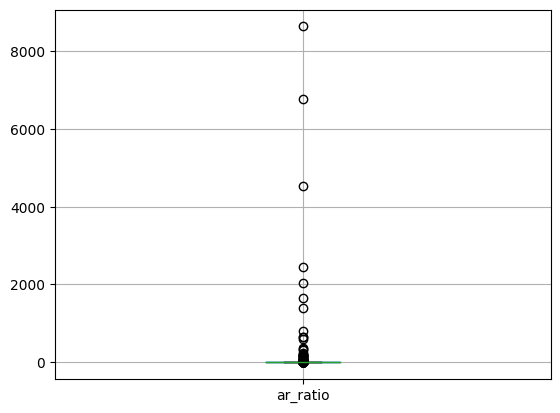

In [ ]:
# create the assets to revenue ratio
df['ar_ratio'] = df['total asset']/df['revenue']
print(df['ar_ratio'].describe())
df.boxplot(column='ar_ratio');

We have 6 outliers with the ratio of 1000+. Let's remove them.

In [ ]:
df = df[df['ar_ratio']<50]
print(df.shape)

(1690, 15)


Create a binary variable that is 1 if the assets to revenue ratio is above its median and 0 otherwise.

This is the **dependent variable** (label) that we'll try to predict.

In [ ]:
df['HIGH_ARR'] = (df['ar_ratio'].gt(df['ar_ratio'].median())).astype(int)

# Asset Intensity Ratio

In [ ]:
df['asset_intensity']=df['revenue']/df['total asset']

Due to Colab's RAM limitations, limit the description size. We'll only keep 1st sentence of each description. In case if you have Pro subscription you can increase the number of sentences/try random sentences from descriptions/use full descriptions. (Observed improvement is marginal.)

# Three Financial Ratios

* Quick ratio: (Current Assets - Inventory) / Current
Liabilities The quick ratio measures the liquidity of a company by measuring how well its current assets could cover its current liabilities. Here, I want to see how well these companies cover their short term liabilities within a shorter time.

* Current ratio: Current Assets / Current Liabilities Similar to Quick Ratio, current ratio measures a company's ability to pay short term liabilities with its current assets. On the other hand, the current ratio is more appropriate to show what resources a company has to pay its short term liabilities within 12 months.

* Return on Assets: Net Income / Total Assets Return on Assets shows a company's profitability based on its total assets. For this assignment, I want to see how efficient companies are using their assets to generate profit.


In [ ]:
df.columns

Index(['datadate', 'fyear', 'ticker', 'conm', 'current asset', 'total asset',
       'inventories', 'current liabilities', 'liabilities', 'net income',
       'revenue', 'sales/turnover', 'costat', 'description', 'ar_ratio',
       'HIGH_ARR', 'asset_intensity'],
      dtype='object')

In [ ]:
df['quick ratio']=(df['current asset']-df['inventories'])/df['current liabilities']
df['current ratio']=df['current asset']/df['current liabilities']
df['ROA']=df['net income']/df['total asset']

In [ ]:
df['quick ratio'].describe()


count    1690.000000
mean        1.955605
std         2.248591
min         0.090486
25%         0.855237
50%         1.276287
75%         2.177798
max        25.441970
Name: quick ratio, dtype: float64

In [ ]:
df['current ratio'].describe()

count    1690.000000
mean       -0.007352
std         0.263005
min        -2.665283
25%        -0.023754
50%         0.035726
75%         0.080925
max         5.019803
Name: ROA, dtype: float64

In [ ]:
df['ROA'].describe()

count    1690.000000
mean       -0.007352
std         0.263005
min        -2.665283
25%        -0.023754
50%         0.035726
75%         0.080925
max         5.019803
Name: ROA, dtype: float64

Print out the general information about the three financial ratios that I created.

In [ ]:
df['HIGH_quick_ratio'] = (df['quick ratio'].gt(df['quick ratio'].median())).astype(int)
df['HIGH_current_ratio'] = (df['current ratio'].gt(df['current ratio'].median())).astype(int)
df['HIGH_ROA'] = (df['ROA'].gt(df['ROA'].median())).astype(int)

Create a binary variable that is 1 if the net profit margin/inventory turnover/return on equity ratio is above its median and 0 otherwise.

These are the dependent variables (label) that we'll try to predict.

In [ ]:
df.head()

,datadate,fyear,ticker,conm,current asset,total asset,inventories,current liabilities,liabilities,net income,...,HIGH_ARR,asset_intensity,quick ratio,current ratio,ROA,HIGH_quick_ratio,HIGH_current_ratio,HIGH_ROA,token_count,text
0,2023-05-31,2022,AIR,AAR CORP,1097.900,1833.100,624.700,351.500,734.000,90.200,...,0,1.085920,1.346230,3.123471,0.049206,1,1,1,314,AAR Corp. provides products and services to co...
1,2023-12-31,2023,AAL,AMERICAN AIRLINES GROUP INC,13572.000,63058.000,2400.000,22062.000,68260.000,822.000,...,0,0.837134,0.506391,0.615175,0.013036,0,0,0,127,"American Airlines Group Inc., through its subs..."
2,2023-12-31,2023,PNW,PINNACLE WEST CAPITAL CORP,1926.967,24661.153,493.547,2889.347,18376.291,501.557,...,1,0.190421,0.496105,0.666921,0.020338,0,0,0,141,"Pinnacle West Capital Corporation, through its..."
4,2023-12-31,2023,ABT,ABBOTT LABORATORIES,22670.000,73214.000,6570.000,13841.000,34387.000,5723.000,...,1,0.547832,1.163211,1.637887,0.078168,0,0,1,299,"Abbott Laboratories discovers, develops, manuf..."
5,2023-12-31,2023,AMD,ADVANCED MICRO DEVICES,16768.000,67885.000,4351.000,6689.000,11993.000,854.000,...,1,0.334094,1.856331,2.506802,0.012580,1,1,0,335,"Advanced Micro Devices, Inc. operates as a sem..."


In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
# Count the number of tokens in the 'text' column
df['token_count'] = df['description'].apply(lambda x: len(word_tokenize(x)))
print(df.shape)
df

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


(1690, 24)


,datadate,fyear,ticker,conm,current asset,total asset,inventories,current liabilities,liabilities,net income,...,ar_ratio,HIGH_ARR,asset_intensity,quick ratio,current ratio,ROA,HIGH_quick_ratio,HIGH_current_ratio,HIGH_ROA,token_count
0,2023-05-31,2022,AIR,AAR CORP,1097.900,1833.100,624.700,351.500,734.000,90.200,...,0.920878,0,1.085920,1.346230,3.123471,0.049206,1,1,1,314
1,2023-12-31,2023,AAL,AMERICAN AIRLINES GROUP INC,13572.000,63058.000,2400.000,22062.000,68260.000,822.000,...,1.194552,0,0.837134,0.506391,0.615175,0.013036,0,0,0,127
2,2023-12-31,2023,PNW,PINNACLE WEST CAPITAL CORP,1926.967,24661.153,493.547,2889.347,18376.291,501.557,...,5.251533,1,0.190421,0.496105,0.666921,0.020338,0,0,0,141
4,2023-12-31,2023,ABT,ABBOTT LABORATORIES,22670.000,73214.000,6570.000,13841.000,34387.000,5723.000,...,1.825376,1,0.547832,1.163211,1.637887,0.078168,0,0,1,299
5,2023-12-31,2023,AMD,ADVANCED MICRO DEVICES,16768.000,67885.000,4351.000,6689.000,11993.000,854.000,...,2.993166,1,0.334094,1.856331,2.506802,0.012580,1,1,0,335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2321,2023-03-31,2022,LPG,DORIAN LPG LTD,236.299,1708.914,2.642,94.597,835.068,172.444,...,4.357796,1,0.229474,2.470025,2.497954,0.100909,1,1,1,67
2322,2023-12-31,2023,APG,API GROUP CORPORATION,2582.000,7590.000,150.000,1807.000,4722.000,153.000,...,1.095554,0,0.912780,1.345877,1.428888,0.020158,1,0,0,222
2323,2023-12-31,2023,NVT,NVENT ELECTRIC PLC,1336.100,6161.700,485.400,733.600,3019.600,567.100,...,1.888007,1,0.529659,1.159624,1.821292,0.092036,0,1,1,304
2324,2023-12-31,2023,ACA,ARCOSA INC,912.000,3577.900,401.800,431.200,1245.900,159.200,...,1.550284,1,0.645043,1.183210,2.115028,0.044495,0,1,1,238


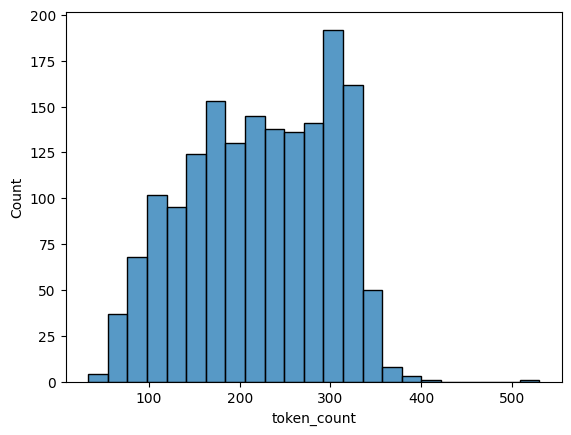

In [ ]:
import seaborn as sns
sns.histplot(data=df, x="token_count");

Looks like most descriptions are around 200 to 300 words.

In [ ]:
import re
# Function to remove unusual characters
def remove_unusual_characters(text):
    pattern = r'[^a-zA-Z0-9.,?! ]'  # Pattern to match common English characters, numbers, and punctuation
    text = re.sub(pattern, '', text)
    return text

# Apply the function to the 'text' column
df['text'] = df['description'].apply(remove_unusual_characters)

In [ ]:
# Remove very long descriptions
lower_threshold = df['token_count'].quantile(0.00)
upper_threshold = df['token_count'].quantile(0.99)

# Trim the DataFrame based on the 1% thresholds
trimmed_df = df[(df['token_count'] >= lower_threshold) & (df['token_count'] <= upper_threshold)]

trimmed_df.head(5)

,datadate,fyear,ticker,conm,current asset,total asset,inventories,current liabilities,liabilities,net income,...,HIGH_ARR,asset_intensity,quick ratio,current ratio,ROA,HIGH_quick_ratio,HIGH_current_ratio,HIGH_ROA,token_count,text
0,2023-05-31,2022,AIR,AAR CORP,1097.900,1833.100,624.700,351.500,734.000,90.200,...,0,1.085920,1.346230,3.123471,0.049206,1,1,1,314,AAR Corp. provides products and services to co...
1,2023-12-31,2023,AAL,AMERICAN AIRLINES GROUP INC,13572.000,63058.000,2400.000,22062.000,68260.000,822.000,...,0,0.837134,0.506391,0.615175,0.013036,0,0,0,127,"American Airlines Group Inc., through its subs..."
2,2023-12-31,2023,PNW,PINNACLE WEST CAPITAL CORP,1926.967,24661.153,493.547,2889.347,18376.291,501.557,...,1,0.190421,0.496105,0.666921,0.020338,0,0,0,141,"Pinnacle West Capital Corporation, through its..."
4,2023-12-31,2023,ABT,ABBOTT LABORATORIES,22670.000,73214.000,6570.000,13841.000,34387.000,5723.000,...,1,0.547832,1.163211,1.637887,0.078168,0,0,1,299,"Abbott Laboratories discovers, develops, manuf..."
5,2023-12-31,2023,AMD,ADVANCED MICRO DEVICES,16768.000,67885.000,4351.000,6689.000,11993.000,854.000,...,1,0.334094,1.856331,2.506802,0.012580,1,1,0,335,"Advanced Micro Devices, Inc. operates as a sem..."


In [ ]:
trimmed_df=trimmed_df[trimmed_df["ticker"]!="LLY"] # these 2 have special characters in description, hence removed
trimmed_df=trimmed_df[trimmed_df["ticker"]!="BIIB"]
trimmed_df=trimmed_df.reset_index(drop=True)

In [ ]:
from nltk.tokenize import sent_tokenize
# Function to keep first three sentences
def keep_n_sentences(text):
    sentences = sent_tokenize(text)
    first_three_sentences = sentences[:1]
    return ' '.join(first_three_sentences)

# Apply the function to the 'text' column
trimmed_df['text'] = trimmed_df['text'].apply(keep_n_sentences)

In [ ]:
trimmed_df.head(3)

,datadate,fyear,ticker,conm,current asset,total asset,inventories,current liabilities,liabilities,net income,...,HIGH_ARR,asset_intensity,quick ratio,current ratio,ROA,HIGH_quick_ratio,HIGH_current_ratio,HIGH_ROA,token_count,text
0,2023-05-31,2022,AIR,AAR CORP,1097.900,1833.100,624.700,351.500,734.000,90.200,...,0,1.085920,1.346230,3.123471,0.049206,1,1,1,314,AAR Corp. provides products and services to co...
1,2023-12-31,2023,AAL,AMERICAN AIRLINES GROUP INC,13572.000,63058.000,2400.000,22062.000,68260.000,822.000,...,0,0.837134,0.506391,0.615175,0.013036,0,0,0,127,"American Airlines Group Inc., through its subs..."
2,2023-12-31,2023,PNW,PINNACLE WEST CAPITAL CORP,1926.967,24661.153,493.547,2889.347,18376.291,501.557,...,1,0.190421,0.496105,0.666921,0.020338,0,0,0,141,"Pinnacle West Capital Corporation, through its..."


# Preparing the predictor and DistilBERT model

**Note**. Please enable GPU in Edit > Notebook settings > Hardware accelerator.

Load a pre-trained BERT model.

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights, max_length=2)
model = model_class.from_pretrained(pretrained_weights)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Tokenize the textual data for DistilBERT.

In [ ]:
trimmed_df.description[12]

'ABM Industries Incorporated provides integrated facility solutions in the United States and internationally. The company operates through Business &amp; Industry, Technology &amp; Manufacturing, Education, Aviation, and Technical Solutions segments. It provides janitorial, facilities engineering, parking, custodial, landscaping and ground, and mechanical and electrical services; and vehicle maintenance and other services to rental car providers. The company was founded in 1909 and is headquartered in New York, New York.'

In [ ]:
trimmed_df.text[12]

'ABM Industries Incorporated provides integrated facility solutions in the United States and internationally.'

In [ ]:
tokenized = trimmed_df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

Pad all lists of tokenized values to the same size.

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

(1671, 69)

Create attention mask variable for BERT to ignore (mask) the padding when it's processing its input.

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(1671, 69)

# DistilBERT model

We run the pretrained DistilBERT model on the prepared predictor and keep the result in `last_hidden_states` variable.

In [ ]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids,
                               attention_mask=attention_mask)

# Logistic regression model



Keep the first layer of the hidden states and assign the outcome variable to `labels`.

In [ ]:
trimmed_df

,datadate,fyear,ticker,conm,current asset,total asset,inventories,current liabilities,liabilities,net income,...,HIGH_ARR,asset_intensity,quick ratio,current ratio,ROA,HIGH_quick_ratio,HIGH_current_ratio,HIGH_ROA,token_count,text
0,2023-05-31,2022,AIR,AAR CORP,1097.900,1833.100,624.700,351.500,734.000,90.200,...,0,1.085920,1.346230,3.123471,0.049206,1,1,1,314,AAR Corp. provides products and services to co...
1,2023-12-31,2023,AAL,AMERICAN AIRLINES GROUP INC,13572.000,63058.000,2400.000,22062.000,68260.000,822.000,...,0,0.837134,0.506391,0.615175,0.013036,0,0,0,127,"American Airlines Group Inc., through its subs..."
2,2023-12-31,2023,PNW,PINNACLE WEST CAPITAL CORP,1926.967,24661.153,493.547,2889.347,18376.291,501.557,...,1,0.190421,0.496105,0.666921,0.020338,0,0,0,141,"Pinnacle West Capital Corporation, through its..."
3,2023-12-31,2023,ABT,ABBOTT LABORATORIES,22670.000,73214.000,6570.000,13841.000,34387.000,5723.000,...,1,0.547832,1.163211,1.637887,0.078168,0,0,1,299,"Abbott Laboratories discovers, develops, manuf..."
4,2023-12-31,2023,AMD,ADVANCED MICRO DEVICES,16768.000,67885.000,4351.000,6689.000,11993.000,854.000,...,1,0.334094,1.856331,2.506802,0.012580,1,1,0,335,"Advanced Micro Devices, Inc. operates as a sem..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1666,2023-03-31,2022,LPG,DORIAN LPG LTD,236.299,1708.914,2.642,94.597,835.068,172.444,...,1,0.229474,2.470025,2.497954,0.100909,1,1,1,67,"Dorian LPG Ltd., together with its subsidiarie..."
1667,2023-12-31,2023,APG,API GROUP CORPORATION,2582.000,7590.000,150.000,1807.000,4722.000,153.000,...,0,0.912780,1.345877,1.428888,0.020158,1,0,0,222,"APi Group Corporation provides safety, special..."
1668,2023-12-31,2023,NVT,NVENT ELECTRIC PLC,1336.100,6161.700,485.400,733.600,3019.600,567.100,...,1,0.529659,1.159624,1.821292,0.092036,0,1,1,304,"nVent Electric plc designs, manufactures, mark..."
1669,2023-12-31,2023,ACA,ARCOSA INC,912.000,3577.900,401.800,431.200,1245.900,159.200,...,1,0.645043,1.183210,2.115028,0.044495,0,1,1,238,"Arcosa, Inc., together with its subsidiaries, ..."


In [ ]:
trimmed_df.columns

Index(['datadate', 'fyear', 'ticker', 'conm', 'current asset', 'total asset',
       'inventories', 'current liabilities', 'liabilities', 'net income',
       'revenue', 'sales/turnover', 'costat', 'description', 'ar_ratio',
       'HIGH_ARR', 'asset_intensity', 'quick ratio', 'current ratio', 'ROA',
       'HIGH_quick_ratio', 'HIGH_current_ratio', 'HIGH_ROA', 'token_count',
       'text'],
      dtype='object')

# Current Ratio Logistic Regression

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()
labels_current = trimmed_df['HIGH_current_ratio']


Split the data in train and test subsets, train the Logistic Regression on train set and evaluate its accuracy on the test set.

In [ ]:
features

array([[-3.8731530e-01,  1.4961715e-01, -2.8184739e-01, ...,
        -1.6794238e-02,  3.6573648e-01,  2.2608189e-01],
       [-4.8176315e-01,  3.6829803e-02, -4.3625301e-01, ...,
         2.9959239e-02,  8.2230842e-01,  4.8331749e-01],
       [-2.4885997e-01, -1.8762282e-01, -5.5357188e-01, ...,
         2.1956837e-01,  6.4488238e-01,  4.5061004e-01],
       ...,
       [-8.0067977e-02, -6.7734495e-02, -2.4267989e-01, ...,
         9.6594490e-02,  2.3763829e-01,  3.8666850e-01],
       [-4.6502191e-01, -3.0316835e-02, -3.2211864e-01, ...,
        -6.9558399e-04,  3.6244109e-01,  3.6046562e-01],
       [-4.4388208e-01, -1.7108789e-02, -4.2642111e-01, ...,
         1.5334626e-01,  4.4775400e-01,  3.6820418e-01]], dtype=float32)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels_current)
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(train_features, train_labels)
print(lr_clf.score(test_features, test_labels))

0.6507177033492823


In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.512 (+/- 0.00)


# Quick Ratio Logistic Regression

In [ ]:
trimmed_df.columns

Index(['datadate', 'fyear', 'ticker', 'conm', 'current asset', 'total asset',
       'inventories', 'current liabilities', 'liabilities', 'net income',
       'revenue', 'sales/turnover', 'costat', 'description', 'ar_ratio',
       'HIGH_ARR', 'asset_intensity', 'quick ratio', 'current ratio', 'ROA',
       'HIGH_quick_ratio', 'HIGH_current_ratio', 'HIGH_ROA', 'token_count',
       'text'],
      dtype='object')

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()
labels_quick = trimmed_df['HIGH_quick_ratio']


In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels_quick)
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(train_features, train_labels)
print(lr_clf.score(test_features, test_labels))


0.6291866028708134


In [ ]:
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.508 (+/- 0.00)


# Return on Assets Logistic Regression

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()
labels_ROA = trimmed_df['HIGH_ROA']


In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels_ROA)
lr_clf = LogisticRegression(max_iter=5000)
lr_clf.fit(train_features, train_labels)
print(lr_clf.score(test_features, test_labels))


0.631578947368421


In [ ]:
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.503 (+/- 0.00)


All three accuracy are not better than random guessing.


# Why did the model (DistilBERT & Logistic Regression) not work well?

In general, the accuracy for the prediction of 3 ratios is quite low, hovering around 0.5, which indicates it is the same as guessing. There are some reasons why this happened:



*  Limited Textual analysis: Since I don't have enough computational power, I can only use the first sentence as training data for DistilBERT model, therefore, it is not enough training data. If I had more computational power to analyze the whole description, it would improve the model's performance. In an ideal case, if I had computational power to analyze the whole textual financial statement, I believe that the model performance will drastically improve.




*  Complex analysis between textual data and financial ratio, it is difficult to predict the financial ratio of a company based on a very small amount of textual data and the relationship is quite complex.